# Optical Pumping Time for PPM sample

For a given optical power, what is the characteristic time to pump ensemble to |0> state?

2022-11-10

* 930 - 950: adjusted stage. optical power at 50 microW. first focus reflected light to camera. then adjusted stage to maximize count rate on SPCM. piezo stage z = 65 microns. count rate 1.15e6
* 955: move stage z = 35 microns (-30 from max PL rate position). 
  * z = 35 (-30)  count rate = 7.4e5
  * z = 40 (-25)  count rate = 7.6e5
  * z = 45 (-20)  count rate = 7.6e5
  * z = 50 (-15). count rate = 7.5e5 
  * z = 55 (-10). count rate = 8.5e5
  * z = 60 (-5).  count rate = 9.8e5
  * z = 65 (0)               = 1.15e6
  
* leave at z = 35 (-30)
* 10:00 confocal scan. NB during scan observed vertical line artifact. Probably related to stage. See scan below
* chose position 40, 60
* measuring optical pumping time with NO RF @ 10, 25, 50 and 100 microW. Stopped bc @ 100 microW, count rate is 2e6 cps, and is becoming more non-linear. Will need to add ND filters to PL collection path before acquiring data at higher power.  Also, we might be limited because of pulse blaster programming issues. Current clock os 10 microseconds wide, and would like faster by 100x. 
    

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import optimize
import copy
from scipy.optimize import leastsq
import scipy 

import logging


In [4]:
import qt3utils.experiments.ramsey
import qt3utils.experiments.cwodmr
import qt3utils.experiments.podmr
import qt3utils.experiments.rabi

from qt3utils.pulsers.pulseblaster import PulseBlasterRamHahnDD, PulseBlasterCWODMR, PulseBlasterPulsedODMR, PulseBlasterHoldAOM, PulseBlasterArb
import qt3utils.nidaq
import qcsapphire
import qt3rfsynthcontrol

import nipiezojenapy
import qt3utils.datagenerators as datasources
import qt3utils.datagenerators.piezoscanner
import qt3utils.nidaq.config

In [420]:
import pickle
def save_file(name, data):
    with open(name, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_file(name):
    with open(name, 'rb') as handle:
        return pickle.load(handle)

# Set Logging Levels

This controls output print statements, which can be useful for debugging and knowing that scans are running

In [7]:
logging.basicConfig(level=logging.WARNING)

In [52]:
qt3utils.experiments.cwodmr.logger.setLevel(logging.WARNING)
datasources.daqsamplers.logger.setLevel(logging.INFO)

# Create objects to control hardware

In [9]:
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [10]:
aom_hold = PulseBlasterHoldAOM(pb_board_number=0)

In [301]:
aom_hold.program_pulser_state()
aom_hold.start() #do this to during confocal san
#if you get an error here, change the pb_board_number during instantiation of the object in cell above

<IPython.core.display.Javascript object>


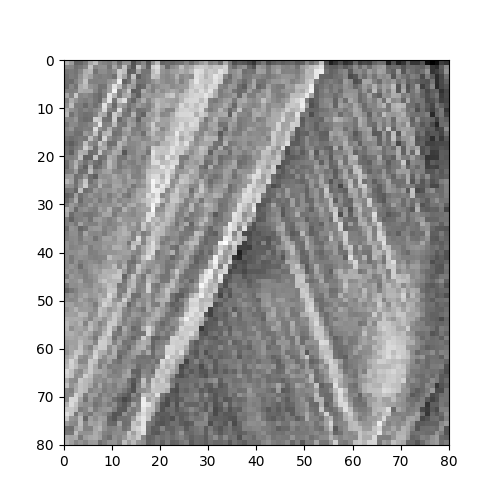

In [12]:
scan_file = 'large_scan_x0t80_y0t80_nov10.npy'
confocal_scan = np.load(scan_file)
plt.figure(figsize=(5,5))
plt.imshow(confocal_scan, cmap='Greys_r', extent = [0,80,80,0])

In [ ]:
# NB - some sort of vertical artifact in scan. Saw it yesterday. Something related to the stage? 

# Use Arbitrary pulse blaster object to create optical pump, followed by >> T1 time

In [303]:
arb_pulser = PulseBlasterArb(0)

In [304]:
arb_pulser.experimental_conditions()

{'full_cycle_width': 0, 'clock_period': None, 'channel_settings': []}

In [305]:
arb_pulser.reset()
arb_pulser.add_channels([0,16], 500e-6, 1000e-6) #aom  #one millisecond
arb_pulser.add_channels([3,19], 0, 10e-6) #trigger
arb_pulser.set_clock_channels([2,18], 10e-6)
arb_pulser.set_full_cycle_length(15000e-6) # 15 milliseconds should be long enough for ensemble to relax to boltzmann dist

In [306]:
arb_pulser.experimental_conditions()

{'full_cycle_width': 0.015,
 'clock_period': 1e-05,
 'channel_settings': [{'channel': 0, 'start': 0.0005, 'width': 0.001},
  {'channel': 16, 'start': 0.0005, 'width': 0.001},
  {'channel': 3, 'start': 0, 'width': 1e-05},
  {'channel': 19, 'start': 0, 'width': 1e-05}]}

In [307]:
N_clock_ticks_per_cycle = arb_pulser.program_pulser_state()

In [308]:
N_cycles = 5000

In [309]:
data_sampler = datasources.NiDaqDigitalInputRateCounter(clock_rate = np.round(1./arb_pulser.clock_period, 9), 
                                                       clock_terminal = 'PFI12', trigger_terminal = 'PFI1',
                                                       num_data_samples_per_batch = N_clock_ticks_per_cycle*N_cycles)

In [310]:
data_sampler.start()
data, num_samples = data_sampler._read_samples()
data_sampler.stop()

INFO:qt3utils.datagenerators.daqsamplers:starting counter task
INFO:qt3utils.datagenerators.daqsamplers:waiting for 82.500000 seconds for data acquisition.
INFO:qt3utils.datagenerators.daqsamplers:reading data
INFO:qt3utils.datagenerators.daqsamplers:returned 7500000 samples


In [311]:
summed_trace = data.reshape(N_cycles, N_clock_ticks_per_cycle).sum(axis=0)
summed_trace /= summed_trace.max()

In [312]:
daq_time =  np.round(N_clock_ticks_per_cycle *arb_pulser.clock_period, 9)

In [406]:
def square_with_ramp(x, offset, boltzman_offset, normalize, start_time, width, time_constant):

    output = np.ones(len(x))*offset
    for i, x_i in enumerate(x):
        if (x_i > start_time) and (x_i <= (start_time + width)):
            output[i] = (normalize - boltzman_offset) * (1 - np.exp(-(x_i - start_time)/time_constant)) + boltzman_offset
            
    
    return output

# def square_with_ramp(x, offset, norm1, norm2, amp, start_time, width, time_constant):

#     output = np.ones(len(x))*offset
#     for i, x_i in enumerate(x):
#         if (x_i > start_time) and (x_i <= (start_time + width)):
#             output[i] = norm1 + (1 - norm2)*np.exp(-(x_i - start_time)/time_constant)
            
            
    
#     return output

def square_with_ramp(x, offset, boltzman_offset, normalize, other_offset, start_time, width, time_constant):

    output = np.ones(len(x))*offset
    for i, x_i in enumerate(x):
        if (x_i > start_time) and (x_i <= (start_time + width)):
            output[i] = (normalize - boltzman_offset) * (1 - np.exp(-(x_i - start_time)/time_constant)) + other_offset
            
    
    return output

In [407]:
x_data = np.linspace(0, daq_time, N_clock_ticks_per_cycle, endpoint=False)*1e6
params = [0,.6,1, .5, 500, 1000, 50]


In [408]:
p_opt, p_cov = scipy.optimize.curve_fit(square_with_ramp, x_data, summed_trace, p0=params, bounds = (0, np.inf))

In [409]:
p_opt

array([1.72874346e-03, 7.97738951e-01, 8.72735927e-01, 9.05177834e-01,
       4.98208050e+02, 1.00000000e+03, 2.89972581e+01])

In [410]:
y_guess = square_with_ramp(x_data,*params)

<IPython.core.display.Javascript object>


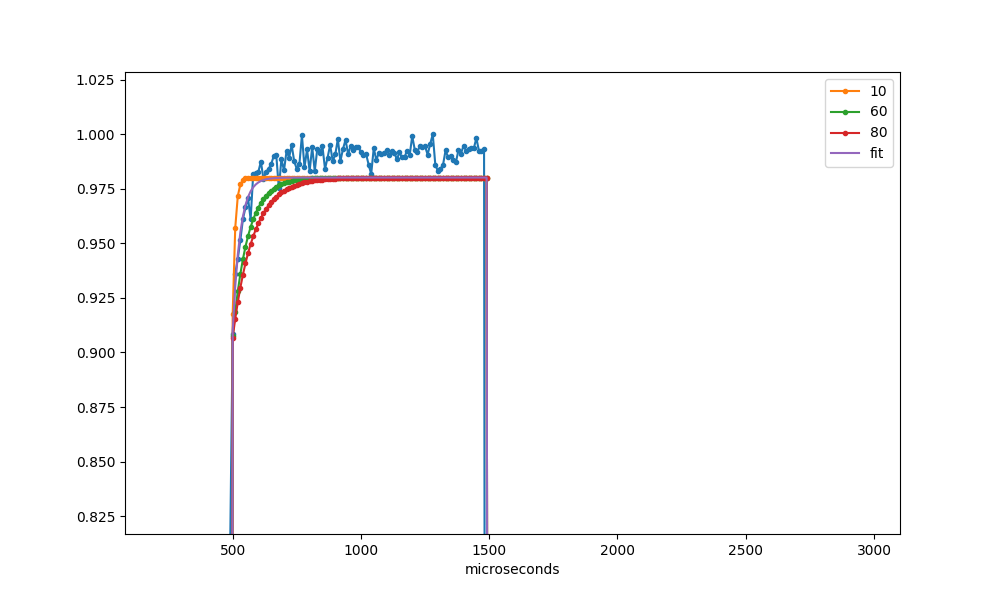

In [411]:
plt.figure(figsize=(10,6))
plt.plot(x_data, summed_trace, '.-')
params = copy.copy(p_opt)
for time_const in [10, 60, 80]:
    params[-1] = time_const
    y_guess = square_with_ramp(x_data,*params)
    plt.plot(x_data, y_guess, '.-', label = time_const)
plt.plot(x_data, square_with_ramp(x_data,*p_opt), label = 'fit')

plt.xlabel('microseconds')
plt.legend()

<IPython.core.display.Javascript object>


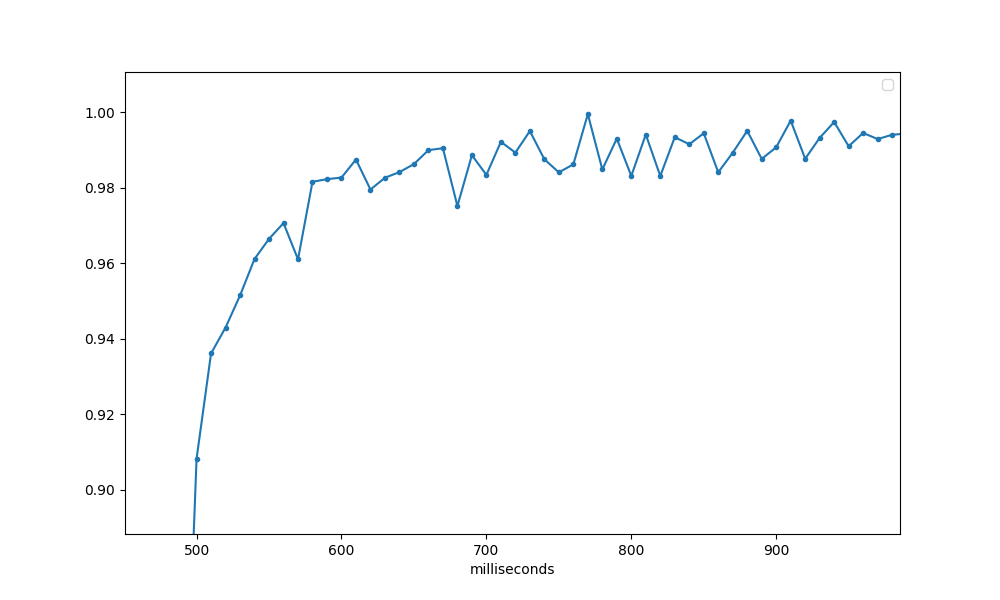

In [390]:
plt.figure(figsize=(10,6))
plt.plot(x_data, summed_trace, '.-')
# params = copy.copy(p_opt)
# for time_const in [10, 60, 80]:
#     params[-1] = time_const
#     y_guess = square_with_ramp(x_data,*params)
#     plt.plot(x_data, y_guess, '.-', label = time_const)
# plt.plot(x_data, square_with_ramp(x_data,*p_opt), label = 'fit')

plt.xlabel('microseconds')
plt.legend()

In [395]:
summed_trace_50microW = copy.deepcopy(summed_trace)

In [ ]:
#from Above, it seems like the time to pump to |0> state with 50 microns is ~140 microseconds~

In [241]:
#decreasing laser power to 25 microW

In [392]:
aom_hold.program_pulser_state()
aom_hold.start() #do this to during confocal san
#if you get an error here, change the pb_board_number during instantiation of the object in cell above

In [393]:
N_clock_ticks_per_cycle = arb_pulser.program_pulser_state()

In [394]:
data_sampler.start()
data, num_samples = data_sampler._read_samples()
data_sampler.stop()

INFO:qt3utils.datagenerators.daqsamplers:starting counter task
INFO:qt3utils.datagenerators.daqsamplers:waiting for 82.500000 seconds for data acquisition.
INFO:qt3utils.datagenerators.daqsamplers:reading data
INFO:qt3utils.datagenerators.daqsamplers:returned 7500000 samples


In [396]:
summed_trace_25microW = data.reshape(N_cycles, N_clock_ticks_per_cycle).sum(axis=0)
summed_trace_25microW /= summed_trace_25microW.max()

<IPython.core.display.Javascript object>


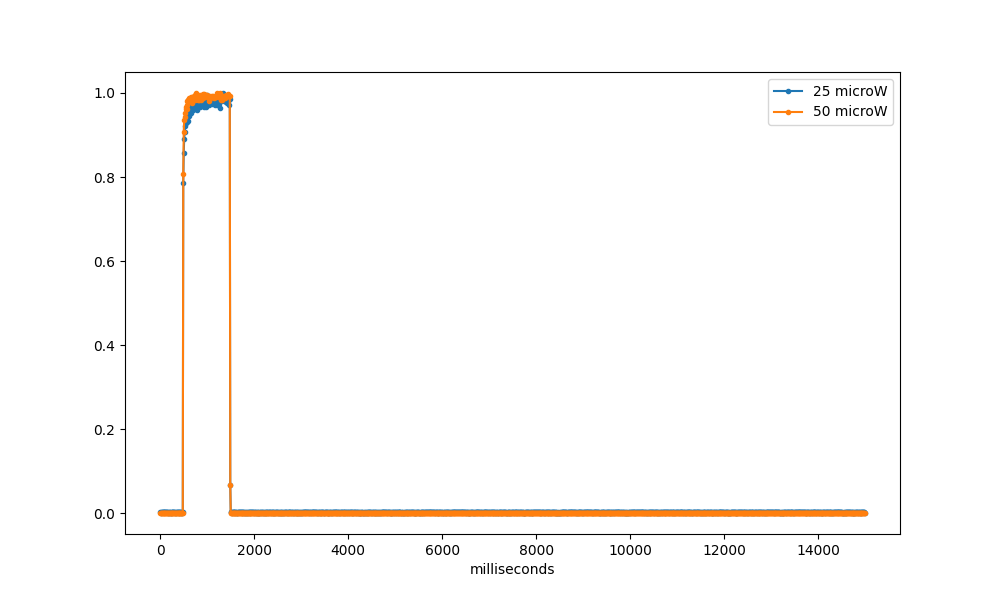

In [399]:
plt.figure(figsize=(10,6))
plt.plot(x_data, summed_trace_25microW, '.-', label='25 microW')
plt.plot(x_data, summed_trace_50microW, '.-', label='50 microW')

# params = copy.copy(p_opt)
# for time_const in [10, 60, 80]:
#     params[-1] = time_const
#     y_guess = square_with_ramp(x_data,*params)
#     plt.plot(x_data, y_guess, '.-', label = time_const)
# plt.plot(x_data, square_with_ramp(x_data,*p_opt), label = 'fit')

plt.xlabel('microseconds')
plt.legend()

In [400]:
aom_hold.program_pulser_state()
aom_hold.start() #do this to during confocal san
#if you get an error here, change the pb_board_number during instantiation of the object in cell above

In [ ]:
# 10 microW

In [401]:
N_clock_ticks_per_cycle = arb_pulser.program_pulser_state()

In [402]:
data_sampler.start()
data, num_samples = data_sampler._read_samples()
data_sampler.stop()

INFO:qt3utils.datagenerators.daqsamplers:starting counter task
INFO:qt3utils.datagenerators.daqsamplers:waiting for 82.500000 seconds for data acquisition.
INFO:qt3utils.datagenerators.daqsamplers:reading data
INFO:qt3utils.datagenerators.daqsamplers:returned 7500000 samples


In [403]:
summed_trace_10microW = data.reshape(N_cycles, N_clock_ticks_per_cycle).sum(axis=0)
summed_trace_10microW /= summed_trace_10microW.max()

<IPython.core.display.Javascript object>


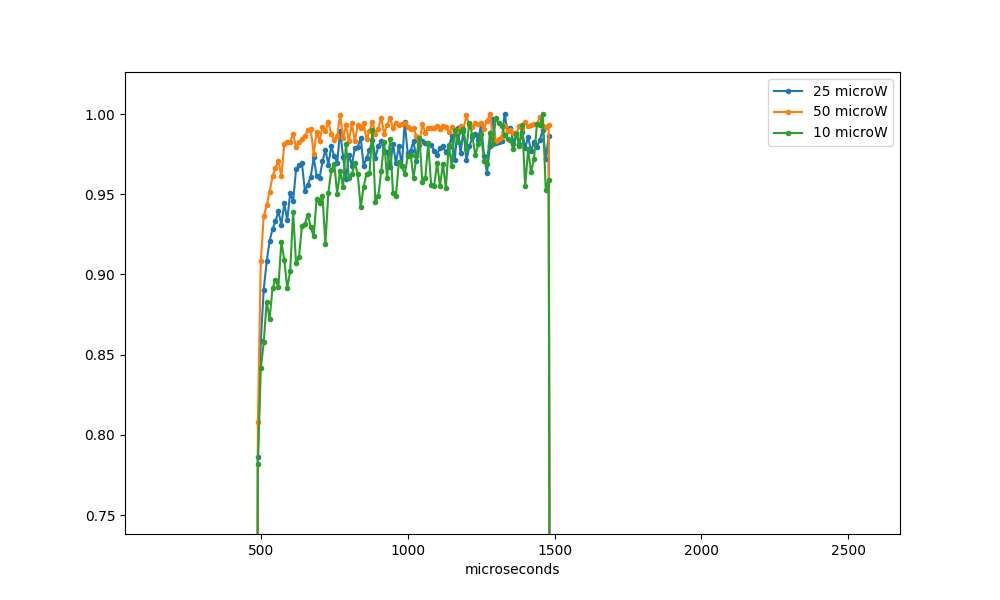

In [424]:
plt.figure(figsize=(10,6))
plt.plot(x_data, summed_trace_25microW, '.-', label='25 microW')
plt.plot(x_data, summed_trace_50microW, '.-', label='50 microW')
plt.plot(x_data, summed_trace_10microW, '.-', label='10 microW')

# params = copy.copy(p_opt)
# for time_const in [10, 60, 80]:
#     params[-1] = time_const
#     y_guess = square_with_ramp(x_data,*params)
#     plt.plot(x_data, y_guess, '.-', label = time_const)
# plt.plot(x_data, square_with_ramp(x_data,*p_opt), label = 'fit')

plt.xlabel('microseconds')
plt.legend()

In [419]:
aom_hold.program_pulser_state()
aom_hold.start() #do this to during confocal san
#if you get an error here, change the pb_board_number during instantiation of the object in cell above

In [413]:
#100 microW

In [415]:
N_clock_ticks_per_cycle = arb_pulser.program_pulser_state()

In [416]:
data_sampler.start()
data, num_samples = data_sampler._read_samples()
data_sampler.stop()

INFO:qt3utils.datagenerators.daqsamplers:starting counter task
INFO:qt3utils.datagenerators.daqsamplers:waiting for 82.500000 seconds for data acquisition.
INFO:qt3utils.datagenerators.daqsamplers:reading data
INFO:qt3utils.datagenerators.daqsamplers:returned 7500000 samples


In [417]:
summed_trace_100microW = data.reshape(N_cycles, N_clock_ticks_per_cycle).sum(axis=0)
summed_trace_100microW /= summed_trace_100microW.max()

<IPython.core.display.Javascript object>


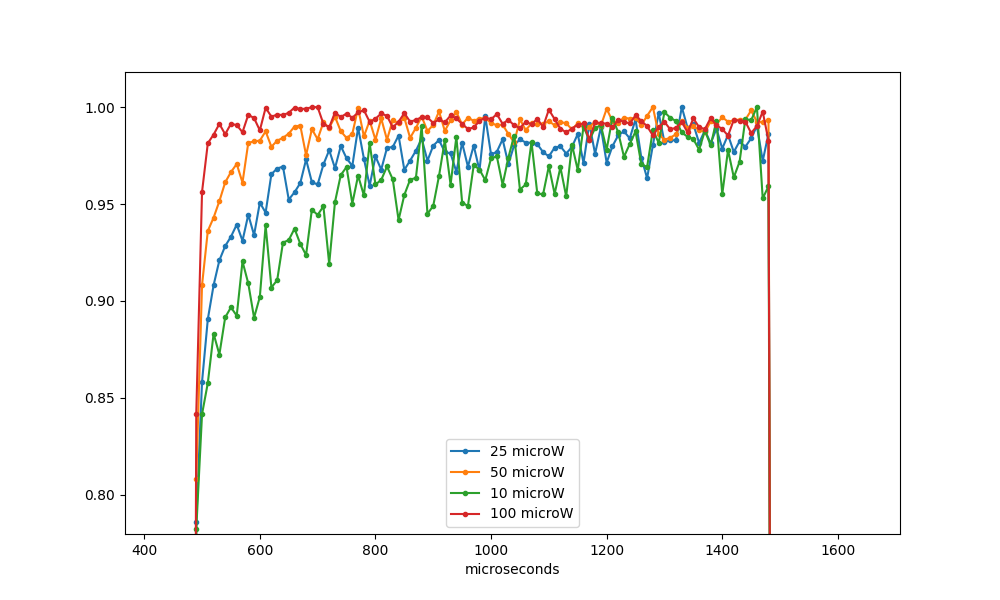

In [418]:
plt.figure(figsize=(10,6))
plt.plot(x_data, summed_trace_25microW, '.-', label='25 microW')
plt.plot(x_data, summed_trace_50microW, '.-', label='50 microW')
plt.plot(x_data, summed_trace_10microW, '.-', label='10 microW')
plt.plot(x_data, summed_trace_100microW, '.-', label='100 microW')

# params = copy.copy(p_opt)
# for time_const in [10, 60, 80]:
#     params[-1] = time_const
#     y_guess = square_with_ramp(x_data,*params)
#     plt.plot(x_data, y_guess, '.-', label = time_const)
# plt.plot(x_data, square_with_ramp(x_data,*p_opt), label = 'fit')

plt.xlabel('microseconds')
plt.legend()

In [ ]:
#at this point, at 100 microW, count rate is near 2e6 cps. So, reaching non-linearity of SPCM
#will need to put in filters

In [421]:
optical_pump_scans = {'10': summed_trace_10microW, 
                      '25': summed_trace_25microW, 
                      '50': summed_trace_50microW, 
                      '100':summed_trace_100microW}

In [423]:
save_file('optical_pump_scans.pickle', optical_pump_scans)

In [ ]:
params = [0,.6,1, .5, 500, 1000, 50]